# <center> Lecture8 : A Simple Linear Regression Model with PyMC </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## 序言  

> ⭐ 在之前的课程中，我们学习了贝叶斯统计方法和使用代码实现统计模型。  
>  
> 然而，我们并没有使用贝叶斯模型深入到真正的心理学研究当中。  
>  
> 从本节课开始，我们将通过一个个真实的案例，带领大家进入心理学贝叶斯统计分析的世界。

## 研究示例： 自我加工优势 (Self-prioritization Effect, SPE)  

在本节课，我们关注的研究问题是 “自我作为人类独特的心理概念，是否在也会促进认知加工的表现？”。  

特别地，我们关注的是自我在知觉匹配任务中的作用，**探究自我和他人条件下，人们的认知加工差异，尤其是在反应时间上的表现。**  

> 探究自我加工的优势通畅使用匹配范式任务中“自我（self）”和“他人（other）”的认知匹配之间的关系 (Sui et al., 2012)。  
> * 在自我匹配任务中，被试首先学习几何图形和身份标签的关系。例如，三角形代表自我；圆形代表他人。在随后的知觉匹配判断任务中，需要判断所呈现的几何图形和文字标签是否与之前学习的关系相匹配。  
> * 想象一下你在完成自我匹配任务时，面对不同的刺激：有时你可能会觉得某个“自我”相关的图像比“他人”相关的更具吸引力，或许这反映了你对自己本身具有更多的关注。  

![Image Name](https://cdn.kesci.com/upload/smipfxtgj4.png?imageView2/0/w/640/h/640)  

> Sui, J., He, X., & Humphreys, G. W. (2012). Perceptual effects of social salience: Evidence from self-prioritization effects on perceptual matching. Journal of Experimental Psychology: Human Perception and Performance, 38(5), 1105–1117. https://doi.org/10.1037/a0029792  


根据Sui et al., （2012）的文章，我们假设，**在“自我”条件下，个体的反应时间会快于在“他人”条件下的反应时间。** 那么在贝叶斯的框架下，我们应该如何解决我们的研究问题以及验证我们的研究假设是否正确呢？  

![Image Name](https://cdn.kesci.com/upload/smkhdwv5zt.png?imageView2/0/w/720)  

在本节课中，我们将学习如何使用大家所熟悉的简单线性模型 (linear regression model) 来检验心理学效应。  

包括以下内容：  

1. **简单线性模型**。  
2. **先验预测检验**。  
3. 模型拟合和诊断。  
4.  后验推理。  
5. **模型检验 (后验预测检验)**。  

<div style="padding-bottom: 20px;"></div>

我们使用的数据来自于Kolvoort等人（2020），该数据集包含了多个被试在自我匹配范式下的行为数据。数据集涉及了不同年龄、性别、文化背景的健康成年被试。  

- 我们使用 `pandas` 的 `read_csv` 方法来读取数据 `Kolvoort_2020_HBM_Exp1_Clean.csv` (数据已经预先存放在和鲸平台中)。  
- 数据包含多个变量，选择我们需要的`Label` 表示标签（self / other），`RT_sec` 表示被试的反应时间。  
- 每一行(index)表示一个trial数。  


> * 数据来源: Kolvoort, I. R., Wainio‐Theberge, S., Wolff, A., & Northoff, G. (2020). Temporal integration as “common currency” of brain and self‐scale‐free activity in resting‐state EEG correlates with temporal delay effects on self‐relatedness. Human brain mapping, 41(15), 4355-4374.  


In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 通过 pd.read_csv 加载数据 Kolvoort_2020_HBM_Exp1_Clean.csv
try:
  df_raw = pd.read_csv('/home/mw/input/bayes3797/Kolvoort_2020_HBM_Exp1_Clean.csv')
except:
  df_raw = pd.read_csv('/data/Kolvoort_2020_HBM_Exp1_Clean.csv')

df_raw.head()

,Unnamed: 0,Subject,Age,Handedness,First_Language,Education,Countryself,Countryparents,Shape,Label,Matching,Response,RT_ms,RT_sec,ACC
0,1,201,18,r,English/Farsi,High School,Iran/Canada,Iran,3,2,Matching,1,753,0.753,1
1,2,201,18,r,English/Farsi,High School,Iran/Canada,Iran,3,2,Matching,1,818,0.818,1
2,3,201,18,r,English/Farsi,High School,Iran/Canada,Iran,1,3,Matching,1,917,0.917,1
3,4,201,18,r,English/Farsi,High School,Iran/Canada,Iran,3,2,Matching,1,717,0.717,1
4,5,201,18,r,English/Farsi,High School,Iran/Canada,Iran,3,2,Matching,1,988,0.988,1


In [3]:
# 筛选出被试"201"，匹配类型为"Matching"的数据
df_raw["Subject"] = df_raw["Subject"].astype(str)
df = df_raw[(df_raw["Subject"] == "201") & (df_raw["Matching"] == "Matching")]

# 选择需要的两列
df = df[["Label", "RT_sec"]]

# 重新编码标签（Label）
df["Label"] = df["Label"].map({1: 0, 2: 1, 3: 1})

# #设置索引
df["index"] = range(len(df))
df = df.set_index("index")

# 显示部分数据
df.head()

,Label,RT_sec
index,,
0,1,0.753
1,1,0.818
2,1,0.917
3,1,0.717
4,1,0.988


进一步可视化数据情况  
* 我们使用 `seaborn` 的 `boxplot` 方法来进行可视化。  
* 其中横轴为Label `x="Label"`，纵轴为反应时间 `y="RT_sec"`。  

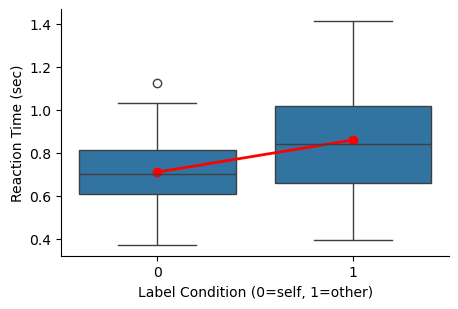

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算每个Label条件下的均值
mean_values = df.groupby('Label')['RT_sec'].mean()

# 使用 seaborn 绘制箱线图，展示 Matching 条件下反应时间的分布情况
plt.figure(figsize=(5, 3.2))
sns.boxplot(x="Label", y="RT_sec", data=df)

plt.plot(mean_values.index, mean_values.values, marker='o', color='r', linestyle='-', linewidth=2)

# 移除上面和右边的边框
sns.despine()

# 添加标签
plt.xlabel("Label Condition (0=self, 1=other)")
plt.ylabel("Reaction Time (sec)")
plt.show()


## 简单线性回归：使用线性模型表示两种条件下反应的差异  

### 频率学派视角下的回归模型  

让我们先回顾在传统频率学派的视角下，回归模型的建立和检验一般基于参数估计和假设检验：  

1. **构建模型**：我们可以使用一个简单线性回归模型，其中反应时间（RT_sec）作为因变量，自变量为二分离散变量（Label）。我们可以将 `self` 编码为 0，`other` 编码为 1，这样模型将估计出“自我”条件相较于“他人”条件在反应时间上的效应。  

模型形式为：  

$$  
   RT_{sec} = \beta_0 + \beta_1 \cdot Label + \epsilon  
$$  

其中，$\beta_0$ 表示“other”条件下的平均反应时间，$\beta_1$ 表示 other 条件下相较于 self 条件的反应时间差异。  

2. **假设检验**：在该模型中，$\beta_1$ 的显著性可以用 t 检验来判断。如果 $\beta_1$ 显著不为 0（例如 $p < 0.05$），则说明自我条件下的反应时间显著不同于他人条件，即存在自我加工的优势。  

3. **模型解释**：若 $\beta_1$ 为负值，则表明自我条件的反应时间较短，暗示自我加工速度较快。


### 贝叶斯视角下的回归模型  

在贝叶斯视角下，回归模型的建立和检验不同于传统的假设检验，而是通过对参数的后验分布进行推断：  

1. **构建贝叶斯模型**：贝叶斯模型和频率学派的回归模型形式相同，但其参数估计基于贝叶斯推断。我们会为 $\beta_0$ 和 $\beta_1$ 指定先验分布（例如，正态分布），并结合观测数据计算其后验分布：  

$$  
RT_{sec} \sim \mathcal{N}(\beta_0 + \beta_1 \cdot Label, \sigma^2)  
$$  

1. **计算后验分布**：使用贝叶斯推断方法（如 MCMC 采样）得到 $\beta_1$ 的后验分布。  

2. **显著性检验**：通过后验分布检验 $\beta_1$ 是否显著，例如计算 $\beta_1 > 0$ 或 $\beta_1 < 0$ 的概率，或计算最高密度区间（HDI）。如果 95% HDI 不包含 0，可以认为自我条件和他人条件在反应时间上的差异是显著的。  

3. **模型解释**：在贝叶斯框架下，我们不仅可以观察参数的点估计（如 $\beta_1$ 的均值），还可以通过后验分布和 HDI 提供更加直观的置信水平解释。

**⭐贝叶斯回归模型的可视化表达**  

*  <span style = "color: orange;">预测值</span> $\mu_i$(即直线上橙色的点)可以写为：$\mu_i = \beta_0 + \beta_1 X_i(1)$  

* 从图上可以看到<span style = "color: orange;">预测值</span>和<span style = "color: gray;">实际值</span> (即灰色的散点)之间存在出入，实际值会在预测值附近波动  

* 那么实际值可以看作服从以$\mu_i$为均值，标准差为$\sigma$的正态分布，即：$Y_i \sim N(\mu_i, \sigma ^ 2)$  

![Image Name](https://cdn.kesci.com/upload/smmabm8nal.png?imageView2/0/w/960/h/960)

*(改编自：https: // saylordotorg.github.io/text_introductory-statistics/s14-03-modelling-linear-relationships.html)*  

<br><br>  

<div style="padding-bottom: 20px;"></div>

**贝叶斯回归模型的数学表达式**  


$$  
\begin{align*}  
\beta_0   &\sim N\left(m_0, s_0^2 \right)  \\  
\beta_1   &\sim N\left(m_1, s_1^2 \right)  \\  
\sigma    &\sim \text{Exp}(\lambda)        \\  
&\Downarrow \\  
\mu_i &= \beta_0 + \beta_1 X_i             \\  
&\Downarrow \\  
Y_i | \beta_0, \beta_1, \sigma &\sim N\left(\mu_i, \sigma^2\right). \\  
\end{align*}  
$$  

* 回归模型需满足如下假设：  

    1. 独立观测假设:每个观测值$Y_i$是相互独立的，即一个被试的反应时间不受其他被试的影响。  

    2. 线性关系假设: 预测值$\mu_i$和自变量$X_i$之间可以用线性关系来描述，即：$\mu_i = \beta_0 + \beta_1 X_i$  

    3. 方差同质性假设： 在任意自变量的取值下，观测值$Y_i$都会以$\mu_i$为中心，同样的标准差$\sigma$呈正态分布变化（$\sigma$ is consistent）  





## 定义先验  

在贝叶斯的分析框架中，我们需要为模型中的每个参数设置先验分布。  

而根据之前的模型公式(数据模型)可发现，我们的$Y$为被试反应时间(RT_sec)，$X$为标签（Label），并且存在三个未知的参数$\beta_0，\beta_1，\sigma$ 。  

因此，我们需要对每个未知的参数定义先验分布。  

$$  
\beta_0    \sim N\left(m_0, s_0^2 \right)  \\  
\beta_1   \sim N\left(m_1, s_1^2 \right) \\  
\sigma \sim \text{Exp}(\lambda)  
$$  


> * 参数的前提假设(assumptions):  
>    * $\beta_0，\beta_1，\sigma$ 之间相互独立  
> * 此外，规定 $\sigma$ 服从指数分布，以限定其值恒为正数  
> * 其中，$m_0，s_0，m_1，s_1$为超参数  
>    * 我们需要根据我们对$\beta_0$和$\beta_1$的先验理解来选择超参数的范围  
>    * 比如，$\beta_1$反映了标签从 self 切换到 other 时，反应时间的平均变化值；$\beta_0$反映了在 other 条件下的基础反应时间  


**指定超参数**  

$$  
\begin{equation}  
\begin{array}{lcrl}  
\text{data:} & \hspace{.05in} &   Y_i | \beta_0, \beta_1, \sigma & \sim N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i \\  

\text{priors:} & & \beta_{0}  & \sim N\left(5, 2^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 1^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(0.3)  \\  
\end{array}  
\end{equation}  
$$  

这里，我们根据生活经验或直觉对超参数进行了定义：  

* 其次，我们假设 $\beta_0$ 服从均值为 5，标准差为 2 的正态分布,代表：  
  * 当实验条件为 self（编码为 0）时，反应时间的平均值大约为 5 秒。  
  * 截距值可能在 3 ± 7 秒 的范围内波动，反映了在 self 条件下的反应时间预估  
  
* 我们假设 $\beta_1$ 服从均值为 0，标准差为 1 的正态分布，代表：  

  * (斜率)将其均值指定为 1，表示我们预期在 self 和 other 条件下的反应时间差异较小。  

    * 这个影响的量是变化的，范围大概在 -1  ± 1。  
   
* 最后，我们假设 $\sigma$ 服从指数分布，其参数为0.3。  
 
  * 参数0.3 意味着标准差通常集中在较小的正数范围内，使反应时间在预测值$\mu_i$附近波动。  
  * 这一设置允许较小到中等的波动，但大部分数据应集中在 0 到 10 秒的合理反应时间范围内。  

<div style="padding-bottom: 20px;"></div>


可视化指定超参下的先验：  

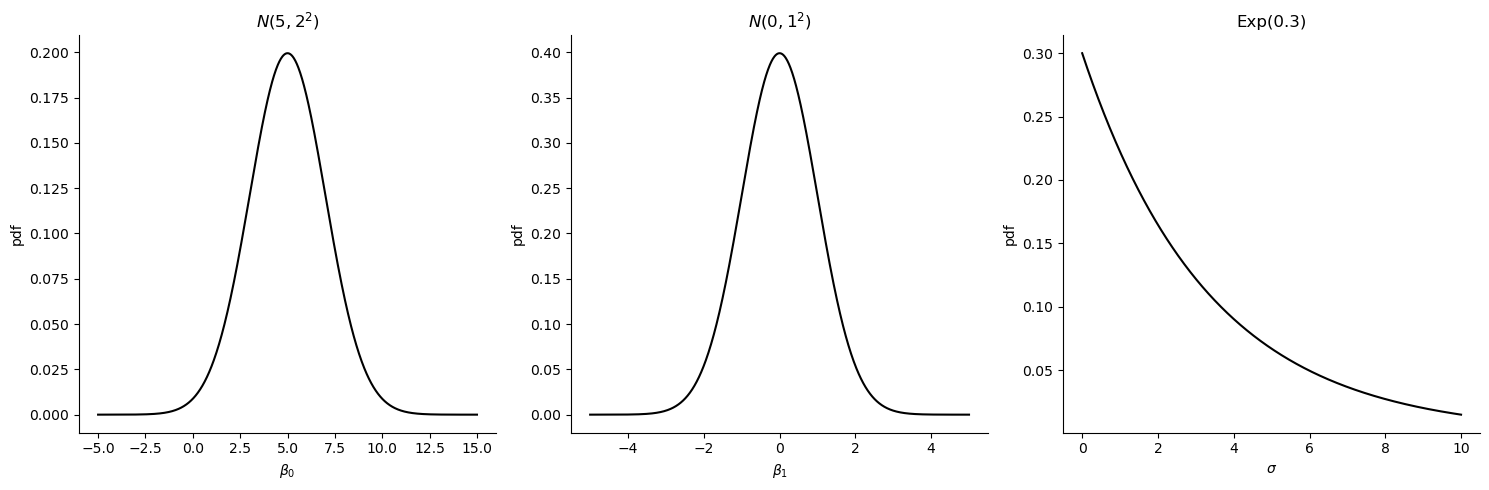

In [5]:
# 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# 定义新的先验分布的参数
mu_beta0 = 5         
sigma_beta0 = 2     
mu_beta1 = 0       
sigma_beta1 = 1   
lambda_sigma = 0.3      

# 生成 beta_0 的先验分布值
x_beta0 = np.linspace(-5, 15, 1000)  
y_beta0 = stats.norm.pdf(x_beta0, mu_beta0, sigma_beta0)

# 生成 beta_1 的先验分布值
x_beta1 = np.linspace(-5, 5, 1000) 
y_beta1 = stats.norm.pdf(x_beta1, mu_beta1, sigma_beta1)

# 生成 sigma 的先验分布值
x_sigma = np.linspace(0, 10, 1000)  
y_sigma = stats.expon.pdf(x_sigma, scale=1/lambda_sigma)

# 绘制先验分布图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 绘制 beta_0 的先验分布
axes[0].plot(x_beta0, y_beta0, 'k-')
axes[0].set_title(r"$N(5, 2^2)$")
axes[0].set_xlabel(r"$\beta_0$")
axes[0].set_ylabel("pdf")

# 绘制 beta_1 的先验分布
axes[1].plot(x_beta1, y_beta1, 'k-')
axes[1].set_title(r"$N(0, 1^2)$")
axes[1].set_xlabel(r"$\beta_1$")
axes[1].set_ylabel("pdf")

# 绘制 sigma 的先验分布
axes[2].plot(x_sigma, y_sigma, 'k-')
axes[2].set_title(r"Exp(0.3)")
axes[2].set_xlabel(r"$\sigma$")
axes[2].set_ylabel("pdf")

# 调整布局并显示图表
sns.despine()
plt.tight_layout()
plt.show()


### 先验预测检验(prior predictive check)  

🤔有些同学可能认为这个先验的定义过于随意，甚至有些不靠谱。 那我们是否可以检验先验的合理性，以及适当的调整这个先验呐？  

**我们通过代码来说明，如何进行先验预测检验**  

首先根据公式，先验模型为：  

$$  
\begin{align*}  
\text{priors:} & & \beta_{0}  & \sim N\left(5, 2^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 1^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(0.3)  \\  
\end{align*}  
$$

**先验预测检验的大致思路**  

1. 在先验中随机抽取200组$\beta_0, \beta_1$值  
2. 生成假数据自变量X  
3. 生成200条 $\beta_0 + \beta_1 X$ 生成预测的反应时间数据  
4. 观察生成的反应时间数据是否在合理范围内，评估先验假设的合适性  


1. 在先验中随机抽取200组$\beta_0, \beta_1$值  

In [6]:
# 设置随机种子确保结果可以重复
np.random.seed(84735)

# 根据设定的先验分布，在其中各抽取200个beta_0,200个beta_1, 200个sigma
beta0_200 = np.random.normal(loc = 5, scale = 2, size = 200)
beta1_200 = np.random.normal(loc = 0, scale = 1 , size = 200)
sigma_200 = np.random.exponential(scale=1/0.3, size=200)

#将结果存在一个数据框内
prior_pred_sample = pd.DataFrame({"beta0":beta0_200,
                                  "beta1":beta1_200,
                                  "sigma":sigma_200})
#查看抽样结果                                
prior_pred_sample

,beta0,beta1,sigma
0,6.037555,-1.138599,4.569418
1,4.364096,-1.004853,0.771582
2,6.831791,-1.189161,5.563509
3,6.575321,0.397816,5.175152
4,4.319496,-1.811424,4.265667
...,...,...,...
195,2.373954,0.138251,7.889629
196,4.910970,0.993390,11.231550
197,5.389999,1.992606,4.559478
198,5.864917,-1.374363,0.147560


2. 生成假数据自变量X  
   
- 这里我们根据现实情况来定义X的取值范围  
- 我们使用 `np.arange`设置自变量 Label 的可能取值  


In [7]:
# 通过np.arange设置Label，0 代表 Self， 1 代表other。
x_sim = np.array([0, 1])

# 查看自变量值
x_sim

array([0, 1])

3. 根据公式 $\mu = \beta_0 + \beta_1 X$ 生成200条回归线, 观察其中的$\mu$是否处在合理的范围内  

- 我们有200次采样，每次采样都有三个参数 beta_0, beta_1, sigma。  

- 结合每次采样的结果，和自变量X，我们可以生成一条直线  

- 重复这个过程200次，我们就能生成200条直线  



> **我们通过一次采样来理解这个过程**  

![Image Name](https://cdn.kesci.com/upload/smivwvoltb.png?imageView2/0/w/720/h/960)  
- **左侧图表**显示了 200 组随机抽取的参数  beta_0, beta_1, sigma 的值。  
    - 这帮助我们直观地看到参数在各自先验分布下的取值范围。  
- **右侧图表**展示了基于抽取的一个特定参数组合绘制的回归线 $Y = \beta_0 + \beta_1 X$  
    - 红色的点表示预测的反应时间在两个条件下的值，蓝色线是连接这两个预测值的回归线。


## 🎯练习1：先验预测  

根据获取的第一条MCMC链的第一组采样参数，结合自变量X的范围，预测 $\mu$ 的值。  

1. 根据回归公式 $\mu = \beta_0 + \beta_1 X$ 预测$\mu$ 的值。  
2. 绘制回归线条。

In [8]:
# 设置随机种子确保结果可以重复
np.random.seed(84735)
# 根据设定的先验分布，在其中各抽取200个beta_0,200个beta_1, 200个sigma
beta0_200 = np.random.normal(loc = 5, scale = 2, size = 200)
beta1_200 = np.random.normal(loc = 0, scale = 1 , size = 200)
sigma_200 = np.random.exponential(scale=1/0.3, size=200)
#将结果存在一个数据框内
prior_pred_sample = pd.DataFrame({"beta0":beta0_200,
                                  "beta1":beta1_200,
                                  "sigma":sigma_200})

# 获取第一组采样参数
beta_0 = prior_pred_sample["beta0"][0]
beta_1 = prior_pred_sample["beta1"][0]

print(f"获取的第一组采样参数值，beta_0:{beta_0:.2f}, beta_1:{beta_1:.2f}")

获取的第一组采样参数值，beta_0:6.04, beta_1:-1.14


In [9]:
#===========================
#     根据回归公式 $\mu = \beta_0 + \beta_1 X$ 预测$\mu$ 的值。
#     已知：自变量（标签），self = 0, other = 1
#===========================
x_sim = np.array([0, 1])
mu = beta_0 + beta_1 * x_sim
print("预测均值 μ (self vs. other):", mu)

预测均值 μ (self vs. other): [6.03755451 4.89895573]


In [10]:
#===========================
#     根据似然模型生成数据 $Y ~ N(\mu, \sigma)$ 的值。
#===========================
sigma = prior_pred_sample["sigma"][0]
y_sim = np.random.normal(mu, sigma)
print("预测数据 Y (self vs. other):", y_sim)

预测数据 Y (self vs. other): [3.45399036 5.87823356]


In [ ]:
#===========================
#     绘制回归线，请设置x轴和y轴的变量
#===========================
x_axis = ...
y_axis = ...

plt.plot(x_axis,y_axis)
plt.xlabel("Label Condition")
plt.ylabel("RT (sec)")  
sns.despine()

In [25]:
# 生成多组数据
N_sim = 200
y_sims = np.array([np.random.normal(mu, 1) for i in range(N_sim)])
# 显示 5 行
y_sims[:5]

array([[7.62038787, 4.53359989],
       [5.27151981, 5.25882789],
       [5.06344845, 3.74443688],
       [5.3377613 , 5.07891478],
       [6.6887649 , 3.7817025 ]])

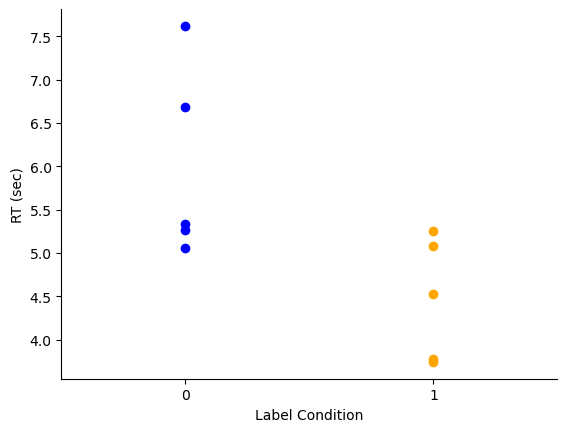

In [36]:
#===========================
#     绘制回归线，请设置x轴和y轴的变量
#===========================
x_0 = [0] * len(y_sims)  # 第一列对应的 x 坐标
y_0 = [row[0] for row in y_sims]  # 第一列的数据

x_1 = [1] * len(y_sims)  # 第二列对应的 x 坐标
y_1 = [row[1] for row in y_sims]  # 第二列的数据

# 绘制散点图
plt.scatter(x_0, y_0, color='blue', label='Column 1')
plt.scatter(x_1, y_1, color='orange', label='Column 2')

plt.xlim(-0.5, 1.5)
plt.xticks([0, 1])
plt.xlabel("Label Condition")
plt.ylabel("RT (sec)")  
sns.despine()

> 重复上述结果200遍，我们就能得到200次先验预测回归线了  

**可视化先验预测结果**  

- 每一条线代表一次抽样生成的预测，因此我们绘制了200条线。  

- 我们可以观察到 self 和 other 条件下的反应时间如何随着自变量（标签Label）变化。  

- 如果先验设置不合理（如过于宽泛的分布），可能导致预测结果在合理范围之外。  
    - 例如，如果我们将 beta_1 设得过大，可能导致预测的 other 条件下的反应时间显著增加或减少，不符合实验数据的预期。  
    - 因此，通过合理的先验设定，我们可以得到更加符合实验背景的预测结果，这有助于模型对真实数据的拟合。

In [23]:
# 通过 np.array 设置实验条件的取值范围，self=0，other=1
x_sim = np.array([0, 1])

# 设置一个空列表，用来储存每一个的预测结果
mu_outcome = []

# 循环生成 200 次先验预测回归线
for i in range(len(prior_pred_sample)):
    # 根据回归公式计算预测值
    mu = prior_pred_sample["beta0"][i] + prior_pred_sample["beta1"][i] * x_sim
    mu_outcome.append(mu)

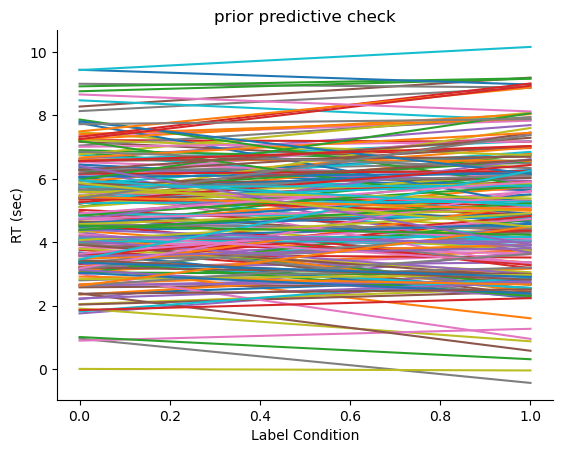

In [24]:
# 画出每一次的先验预测结果
for i in range(len(mu_outcome)):
    plt.plot(x_sim, mu_outcome[i])

plt.title("prior predictive check")
plt.xlabel("Label Condition")
plt.ylabel("RT (sec)")
sns.despine()

### 我们的先验设置的合理吗？  

让我们重新聚焦于我们的研究问题：**在知觉匹配任务中，自我相关信息是否会促进认知加工？** 具体而言，我们探讨自我和他人条件下的认知加工差异，尤其是在反应时间上的表现。  

变量定义：  

- 𝑋：标签（Label）  
    - 在自我匹配范式任务中，标签分为 self 和 other 两种，分别编码为 0 和 1。这些条件用于观察在自我相关和非自我相关条件下的反应时间差异。  

- 𝑌：反应时间（RT）  
    - 表示在 self 或 other 条件下参与者的平均反应时间，通常以秒为单位。我们的目标是通过模型预测 self 和 other 条件下反应时间的差异，并观察其随实验条件的变化。  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def prior_predictive_plot(beta0_mean=0.5, beta0_sd=0.3, beta1_mean=-0.1, beta1_sd=0.04, sigma_rate=0.2, samples=200, seed=84735):
    """
    生成先验预测图。
    
    参数：
    - beta0_mean: float，beta0的均值
    - beta0_sd: float，beta0的标准差
    - beta1_mean: float，beta1的均值
    - beta1_sd: float，beta1的标准差
    - sigma_rate: float，控制sigma的指数分布率参数（lambda = 1/scale）
    - samples: int，生成的样本数量
    - seed: int，随机种子，默认为84735，确保结果可重复
    
    输出：
    - 一个先验预测图
    """
    
    # 设置随机种子
    if seed is not None:
        np.random.seed(seed)
    
    # 根据设定的先验分布抽样
    beta0_samples = np.random.normal(loc=beta0_mean, scale=beta0_sd, size=samples)
    beta1_samples = np.random.normal(loc=beta1_mean, scale=beta1_sd, size=samples)
    sigma_samples = np.random.exponential(scale=1/sigma_rate, size=samples)
    
    # 创建数据框存储样本
    prior_pred_sample = pd.DataFrame({
        "beta0": beta0_samples,
        "beta1": beta1_samples,
        "sigma": sigma_samples
    })

    # 定义实验条件（self=0，other=1）
    x_sim = np.array([0, 1])
    
    # 创建一个空列表存储每次模拟的结果
    mu_outcome = []
    
    # 生成先验预测回归线
    for i in range(samples):
        mu = prior_pred_sample["beta0"][i] + prior_pred_sample["beta1"][i] * x_sim
        mu_outcome.append(mu)
    
    # 绘图
    plt.figure(figsize=(10, 6))
    for i in range(len(mu_outcome)):
        plt.plot(x_sim, mu_outcome[i])
    
    plt.title("Prior Predictive Check")
    plt.xlabel("Label Condition")
    plt.ylabel("RT (sec)")
    sns.despine()
    plt.show()

# 使用示例
prior_predictive_plot()


## 🎯练习2：先验预测  

🤔请大家判断，下图的先验预测合理吗？  


![Image Name](https://cdn.kesci.com/upload/smkk0xc4bq.png?imageView2/0/w/720/h/960)

在实际实验中，我们知道被试的反应时间（RT）不会小于0秒。然而，当前模型的先验预测图中可能会包含一些小于0的反应时间，这显然不符合逻辑.  

通过以下练习,你可以尝试对三个参数的先验分布进行设置，观察它们对反应时间预测的影响。

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#=====================================================
#     请完善代码中...的部分，设置3个参数的值，使先验分布更符合实际情况
#=====================================================

prior_predictive_plot(beta0_mean=...,  # beta 0 的均值
                      beta0_sd=...,    # beta 0 的标准差
                      beta1_mean=...,  # beta 1 的标准差
                      beta1_sd=...,    # beta 1 的标准差
                      samples=200,
                      seed=84735)

## 模型拟合  

### 模型定义  

现在，我们可以结合数据与先验，为参数$(\beta_0, \beta_1, \sigma)$生成后验模型  

* 之后我们可以使用 PyMC 来完成对于模型后验分布的采样过程  


在这之前，我们回顾之前对先验与似然的定义：  

**先验（prior）**  

* > $\beta_{0}   \sim N\left(5, 2^2 \right)$  
  * > 模型的截距项服从均值为 5，标准差为 2 的正态分布。  
* > $\beta_1   \sim N\left(0, 1^2 \right)$  
  * > 模型的斜率项，服从均值为 0，标准差为 1 的正态分布。  
* > $\sigma   \sim \text{Exp}(0.3)$  
  * > 代表误差项的标准差，服从参数为 0.3 的指数分布。  

**似然（likelihood）**  

* > $\mu_i = \beta_0 + \beta_1X_i$  
* > $Y_i {\sim} N\left(\mu_i, \sigma^2\right)$  

---

<div style="padding-bottom: 30px;"></div>

In [9]:
import pymc as pm

with pm.Model() as linear_model:

    # 定义先验分布参数
    beta_0 = pm.Normal("beta_0", mu=5, sigma=2)        
    beta_1 = pm.Normal("beta_1", mu=0, sigma=1)      
    sigma = pm.Exponential("sigma", 3)                    

    # 定义自变量 x
    x = pm.MutableData("x", df['Label'])         

    # 定义 mu，将自变量与先验结合
    mu = beta_0 + beta_1 * x

    # 定义似然：预测值y符合N(mu, sigma)分布
    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df['RT_sec'])  # 实际观测数据 y 是 RT


### 后验采样  

1. 接下来我们使用`pm.sample()`进行mcmc采样  

* 我们指定了4条马尔科夫链，保留的采样数为5000，对于每一个参数，在每条链上都有5000个采样结果  

    * $\left\lbrace \beta_0^{(1)}, \beta_0^{(2)}, \ldots, \beta_0^{(5000)} \right\rbrace$  

    * $\left\lbrace \beta_1^{(1)}, \beta_1^{(2)}, \ldots, \beta_1^{(5000)} \right\rbrace$  
    
    * $\left\lbrace \sigma_1^{(1)}, \sigma_1^{(2)}, \ldots, \sigma_1^{(5000)} \right\rbrace$  


In [10]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with linear_model:
    trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples=True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


2. 在采样结束之后，我们得到采样样本 trace  

- 后验样本储存在`trace.posterior`中，它的数据类型为 xarray。  

  - 包括了两个维度(索引)，第一个维度为链chain，第二个维度为采样draw  
  
  - 包含了3个变量，即3个参数beta_0, beta_1, sigma  

	- 我们可以使用 `trace.posterior['beta_0']`提取后验中的$\beta_0$参数  

	- 我们可以使用 `trace.posterior['beta_0'][0, 10]`提取$\beta_0$第一条链中第10个采样值

**补充 ArviZ inferenceData 介绍**  

`trace` 中的 `inferenceData` 是 PyMC 中用来存储和管理采样结果的格式，专门用于便于分析和可视化。它采用 `ArviZ` 的 `InferenceData` 对象进行封装，包含了多个维度的数据集合，用于存储模型的采样结果、样本统计、后验预测等。以下是 `trace` 中 `inferenceData` 的典型结构和内容：  

1. `posterior`  
`posterior` 是 `InferenceData` 中最核心的一个组，包含了每条链和每次采样的后验分布样本。对于本例子中的模型，`posterior` 包括以下参数：  

- `beta_0`: 表示截距参数的后验分布采样值。  
- `beta_1`: 表示斜率参数的后验分布采样值。  
- `sigma`: 表示残差标准差的后验分布采样值。  

数据结构通常为 `(chain, draw, parameter)`，其中 `chain` 表示不同的链，`draw` 是每条链的样本数量。我们可以用 `posterior` 中的数据来绘制各个参数的后验分布图，分析它们的均值、中位数及不确定性。  

2. `sample_stats`  
`sample_stats` 存储每次采样的统计信息，帮助评估采样质量。这些数据有助于诊断 MCMC 链的收敛性和性能。常见的统计信息包括：  

- `lp`: 对数后验密度 (log-posterior)，用于评估样本的相对“好坏”。  
- `r_hat`: 用于评估链的收敛情况，理想值接近1，若远离1可能表明链未收敛。  
- `ess_bulk` 和 `ess_tail`: 分别为整体和尾部的有效样本数，用于衡量采样的独立性。  
- `diverging`: 若存在divergence，通常表明模型的特定区域无法很好地被估计。  

这些统计信息可以用于诊断和调整模型的采样参数，比如增大 `tune` 或 `draws` 的数量。  

3. `observed_data`  
`observed_data` 包含实际的观测数据，这在本例中为 `df['RT_sec']`。在模型的 `likelihood` 部分指定了 `observed=df['RT_sec']`，因此它也会被存储到 `inferenceData` 中，便于对比观测值和预测值。  

1. `posterior_predictive`  
如果在模型中使用 `pm.sample_posterior_predictive` 来生成后验预测分布，这些预测值会存储在 `posterior_predictive` 中。`posterior_predictive` 包含每条链和每次采样生成的预测值（`y_est`），方便与观测数据（`observed_data`）进行对比，评估模型的预测效果和拟合度。  

1. `prior`  
若通过 `pm.sample_prior_predictive` 生成了先验预测分布，`prior` 会保存这些值。它能帮助我们了解模型在没有观测数据时的先验分布，为参数的选择提供参考。  


<div style="padding-bottom: 30px;"></div>

In [11]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [12]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 5000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999
Data variables:
    beta_0   (chain, draw) float64 0.7118 0.6882 0.6751 ... 0.66 0.6877 0.7321
    beta_1   (chain, draw) float64 0.1974 0.1576 0.186 ... 0.1954 0.1174 0.1842
    sigma    (chain, draw) float64 0.2275 0.235 0.2375 ... 0.2601 0.2101 0.2495
Attributes:
    created_at:                 2024-11-07T10:18:40.942135+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.17.0
    sampling_time:              4.562288761138916
    tuning_steps:               1000

In [13]:
trace.posterior['beta_0']

<xarray.DataArray 'beta_0' (chain: 4, draw: 5000)>
array([[0.71181631, 0.68824043, 0.67506366, ..., 0.70283116, 0.6975889 ,
        0.68674788],
       [0.75716849, 0.67225603, 0.74359224, ..., 0.66479688, 0.6712113 ,
        0.73544392],
       [0.70004016, 0.70770034, 0.68456142, ..., 0.65013829, 0.75404762,
        0.80939225],
       [0.76348376, 0.74819277, 0.70107608, ..., 0.65999984, 0.68771545,
        0.73207527]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999

In [14]:
trace.posterior['beta_0'][0, 10]

<xarray.DataArray 'beta_0' ()>
array(0.7031722)
Coordinates:
    chain    int64 0
    draw     int64 10

### MCMC 诊断  


使用`az.plot_trace()`可视化参数的后验分布

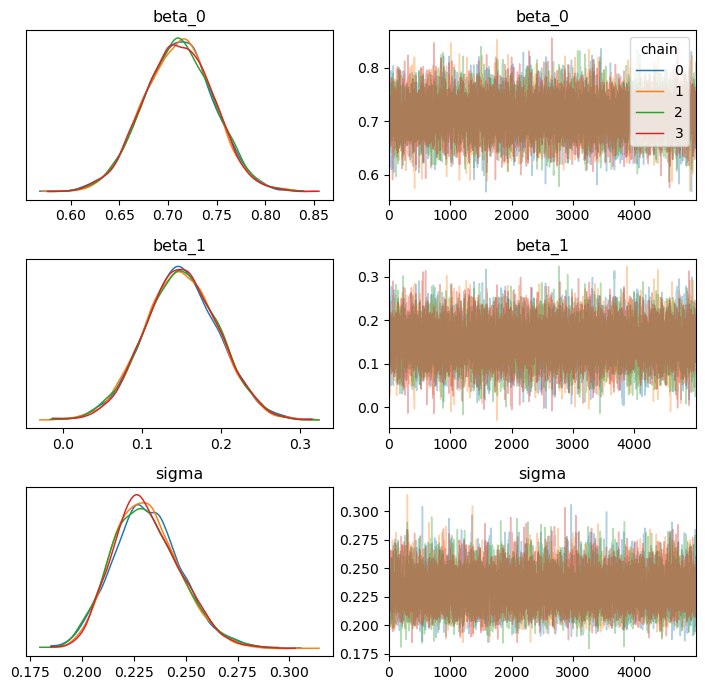

In [15]:
import arviz as az

ax = az.plot_trace(trace, figsize=(7, 7),compact=False,legend=True)
plt.tight_layout()
plt.show()

对于模型的诊断信息 ess_bulk 和 r_hat (当然你可以结合可视化进行诊断)。  
- 其中，各参数的 r_hat 均接近于 1；  
- 各参数的ess_bulk 均大于 400，并且有效样本量占比 (6000/20000)=0.3，大于0.1(即10%)。  

In [16]:
az.summary(trace, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.0,0.0,10224.0,11211.0,1.0
beta_1,0.0,0.0,10341.0,11605.0,1.0
sigma,0.0,0.0,11501.0,11301.0,1.0


## 后验预测  

MCMC 诊断仅能显示采样过程的收敛性和采样质量，而不能直接说明模型在观测数据上的拟合效果或预测能力。为评估模型的预测能力，我们可以进行**后验预测检查**，通过模拟新的数据样本来比较模型生成的数据与实际观测数据的分布是否一致，从而验证模型的合理性和适用性。  

- 为了更全面地反映模型的不确定性，我们可以基于 20000 对参数值生成 20000 条回归线。  

- 这些回归线将展示在 "self" 和 "other" 条件下的预测差异，以及模型在不同参数样本下的预测范围。这种基于后验参数的预测被称为后验预测 (Posterior Prediction)。  

- 在进行后验预测时，我们利用模型后验采样得到的参数进行预测，并结合真实数据生成预测值的分布。  
- 这个过程不仅可以帮助我们检查模型对数据的适配度，还能通过可视化展现预测的不确定性。

### 🎯练习  

根据 **先验预测检验可视化预测结果**的思路，对于后验预测结果进行可视化。  

1. 使用真实数据中的自变量Label  
2. 根据 20000对参数（beta_0, beta_1），与自变量(Label)进行组合，生成了20000条回归线  
3. 绘制后验预测结果  


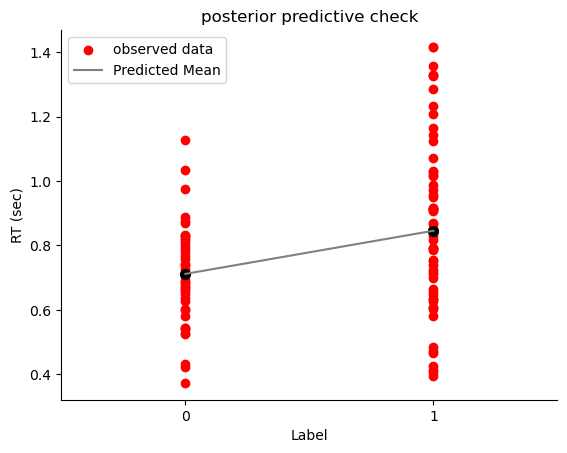

In [17]:
# 通过np.arange设置 x 轴代表 Label，其中 0 代表 Self， 1代表other。
x_sim = np.array([0, 1])

# 选取一组参数来作为预测
beta_0 = trace.posterior["beta_0"].stack(sample=("chain", "draw"))[:2]
beta_1 = trace.posterior["beta_1"].stack(sample=("chain", "draw"))[:2]

# 生成20000条回归线
y_sim_re = beta_0 + beta_1 * x_sim

# 绘制真实数据的散点图
plt.scatter(trace.constant_data.x, trace.observed_data.y_est,c="r", label="observed data")

# 绘制回归线条
plt.plot(x_sim, y_sim_re, c="grey", label = "Predicted Mean")
plt.scatter(x_sim, y_sim_re, color="black", s=50)


# 设置标题等
plt.xlim(-0.5, 1.5) 
plt.xticks([0, 1]) 
plt.title("posterior predictive check")
plt.xlabel("Label")
plt.ylabel("RT (sec)")  
plt.legend()
sns.despine()

**使用`plot_lm` 绘制后验预测的线性模型**  

**代码详解**  

- 与上一段代码最大的不同之处在于，此时需要将`y_model` 存入`trace`中  

- 在`az.plot_lm`中:  
    - `y` 为真实数据中的因变量`df.RT_sec`  
    - `x` 为真实数据中的自变量`df.Label`  
    - `y_model` 为结合后验采样生成的预测值  
    （在图中表示为黄色和灰色的回归线）  

> 😎*跑起来快很多*

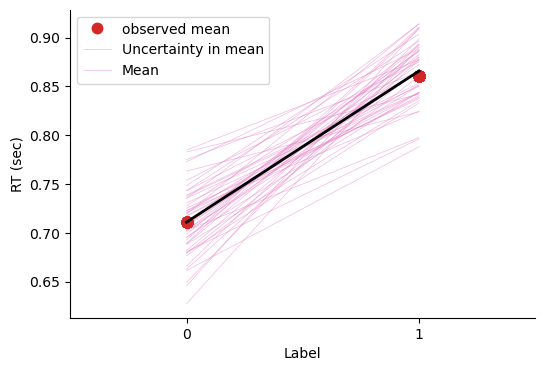

In [18]:
import xarray as xr

# 导入真实的自变量
x_value = xr.DataArray(df.Label)

# 基于后验参数生成y_model
trace.posterior["y_model"] = trace.posterior["beta_0"] + trace.posterior["beta_1"] * x_value
df['Mean RT'] = df.groupby('Label')['RT_sec'].transform('mean')

# 绘制后验预测线性模型
az.plot_lm(
           y= df['Mean RT'],
           x= df.Label,
           y_model = trace.posterior["y_model"],
           y_model_mean_kwargs={"color":"black", "linewidth":2},
           figsize=(6,4),
           textsize=16,
           grid=False)

# 设置坐标轴标题、字体大小
plt.xlim(-0.5, 1.5) 
plt.xticks([0, 1]) 
plt.xlabel('Label')  
plt.ylabel('RT (sec)')  
plt.legend(['observed mean', 'Uncertainty in mean', 'Mean']) 

sns.despine()

### 通过MCMC采样值理解后验预测分布  


* 通过MCMC采样，三个参数各获得了20000个采样值$\left(\beta_0^{(i)},\beta_1^{(i)},\sigma^{(i)}\right)$  

* 根据 20000 组参数值 $\beta_0$ 和 $\beta_1$，可以得到 20000 个均值 $\mu$ 的可能值。然后再根据 $\mu$ 生成预测值 $Y_{\text{new}}$。  
* 20000 个均值 $\mu$ 构成了预测的均值分布：  

$$  
\left[  
\begin{array}{ll}  
\beta_0^{(1)} & \beta_1^{(1)} \\  
\beta_0^{(2)} & \beta_1^{(2)} \\  
\vdots & \vdots \\  
\beta_0^{(20000)} & \beta_1^{(20000)} \\  
\end{array}  
\right]  
\;\; \longrightarrow \;\;  
\left[  
\begin{array}{l}  
\mu^{(1)} \\  
\mu^{(2)} \\  
\vdots \\  
\mu^{(20000)} \\  
\end{array}  
\right]  
$$  

- 为了模拟这个过程，我们首先从后验分布中提取采样结果，并生成每个采样值对应的预测均值 $\mu$。每个均值 $\mu^{(i)}$ 可以通过以下公式计算：  

$$  
\mu^{(i)} = \beta_0^{(i)} + \beta_1^{(i)} X  
$$  

- 然后，在每个均值 $\mu^{(i)}$ 的基础上，加入噪声项 $\epsilon$ 来生成 $Y_{\text{new}}^{(i)}$：  

$$  
Y_{\text{new}}^{(i)} = \mu^{(i)} + \epsilon^{(i)}, \quad \epsilon^{(i)} \sim \mathcal{N}(0, \sigma^{(i)})  
$$  

- 这里，$\epsilon^{(i)}$ 是服从均值为 0，方差为 $\sigma^{(i)}$ 的正态分布。  

> 可以注意到，生成的预测值受到两种变异的影响：  
> * 一是参数估计的不确定性（即 $\beta_0$ 和 $\beta_1$ 的后验分布带来的变异），导致不同样本的均值 $\mu$ 具有差异；  
> * 二是随机误差项 $\epsilon$ 的影响，使得在相同均值 $\mu$ 下生成的预测值 $Y_{\text{new}}$ 仍然存在随机波动。这两种变异共同决定了最终预测值的后验预测分布。  

<div style="padding-bottom: 30px;"></div>


### 提取后验样本并生成预测  

**我们也可以用代码来进行模拟，首先我们先进行单次完整的抽取过程**

In [19]:
# 采样得到的参数后验分布都储存在 trace.posterior中，我们进行一些提取操作
pos_sample = trace.posterior.stack(sample=("chain", "draw"))

# 将每个参数的20000次采样结果存储在数据框中
df_pos_sample = pd.DataFrame({"beta_0": pos_sample["beta_0"].values,
                              "beta_1": pos_sample["beta_1"].values,
                              "sigma": pos_sample["sigma"].values})

# 查看参数
df_pos_sample

,beta_0,beta_1,sigma
0,0.711816,0.197405,0.227486
1,0.688240,0.157603,0.235002
2,0.675064,0.186001,0.237489
3,0.683199,0.189842,0.212226
4,0.712327,0.133783,0.216075
...,...,...,...
19995,0.698971,0.127975,0.213383
19996,0.679192,0.165039,0.206986
19997,0.660000,0.195370,0.260113
19998,0.687715,0.117434,0.210055


In [20]:
# 抽取第一组参数组合，生成正态分布的均值
row_i = 0  
X_i = 1   
mu_i = df_pos_sample.beta_0[row_i] + df_pos_sample.beta_1[row_i] * X_i           
sigma_i = df_pos_sample.sigma[row_i]

# 从正态分布中随机抽取一个值，作为预测值
prediction_i = np.random.normal(
                                loc = mu_i,                                            
                                scale= sigma_i, 
                                size=1)

# 你可以运行该代码块多次，比较在相同参数下，预测值的变化(感受采样变异)。
print(f"mu_i: {mu_i:.2f}, 预测值：{prediction_i[0]:.2f}")

mu_i: 0.91, 预测值：1.12


**使用代码模拟多次后验预测**  

* 通过上述四行代码，我们已经进行了一次完整的后验预测  

* 我们可以写一个循环，重复这个过程20000次  

* 最后的结果中，每一行代表一个参数对；mu 为预测的均值，y_new 为实际生成的预测值。

In [21]:
# 生成两个空列，用来储存每一次生成的均值mu，和每一次抽取的预测值y_new
df_pos_sample['mu'] = np.nan
df_pos_sample['y_new'] = np.nan
X_i = 1
np.random.seed(84735)

# 将之前的操作重复20000次
for row_i in range(len(df_pos_sample)):
    mu_i = df_pos_sample.beta_0[row_i] + df_pos_sample.beta_1[row_i] * X_i
    df_pos_sample["mu"][row_i] = mu_i
    df_pos_sample["y_new"][row_i] = np.random.normal(loc = mu_i,
                                            scale= df_pos_sample.sigma[row_i],
                                            size=1)

In [22]:
df_pos_sample

,beta_0,beta_1,sigma,mu,y_new
0,0.711816,0.197405,0.227486,0.909221,1.027236
1,0.688240,0.157603,0.235002,0.845844,0.771125
2,0.675064,0.186001,0.237489,0.861065,1.078580
3,0.683199,0.189842,0.212226,0.873041,1.040203
4,0.712327,0.133783,0.216075,0.846110,0.772590
...,...,...,...,...,...
19995,0.698971,0.127975,0.213383,0.826947,1.027230
19996,0.679192,0.165039,0.206986,0.844231,1.072505
19997,0.660000,0.195370,0.260113,0.855370,0.783391
19998,0.687715,0.117434,0.210055,0.805150,0.811509


**绘制后验预测分布**  

根据刚刚生成的数据，我们可以分别绘制出 $\mu$ 与 $Y_{new}$ 的后验预测分布图

In [23]:
#查看真实数据中的取值，与后验预测分布作对比
df2 = df.drop(["Mean RT"],axis=1).copy()
print("x=1时y的取值有:", np.array(df2[df2["Label"]==1]))

x=1时y的取值有: [[1.    0.753]
 [1.    0.818]
 [1.    0.917]
 [1.    0.717]
 [1.    0.988]
 [1.    0.95 ]
 [1.    0.657]
 [1.    0.829]
 [1.    1.143]
 [1.    0.756]
 [1.    0.665]
 [1.    0.846]
 [1.    0.839]
 [1.    0.914]
 [1.    0.712]
 [1.    1.33 ]
 [1.    0.786]
 [1.    0.626]
 [1.    0.912]
 [1.    0.725]
 [1.    0.956]
 [1.    0.485]
 [1.    1.417]
 [1.    0.604]
 [1.    0.789]
 [1.    1.327]
 [1.    1.357]
 [1.    0.635]
 [1.    0.871]
 [1.    1.287]
 [1.    0.739]
 [1.    1.331]
 [1.    0.907]
 [1.    1.015]
 [1.    1.125]
 [1.    0.868]
 [1.    0.582]
 [1.    1.233]
 [1.    1.03 ]
 [1.    0.791]
 [1.    1.028]
 [1.    0.918]
 [1.    0.793]
 [1.    0.909]
 [1.    0.646]
 [1.    0.467]
 [1.    0.843]
 [1.    0.61 ]
 [1.    0.972]
 [1.    0.851]
 [1.    1.208]
 [1.    0.473]
 [1.    0.407]
 [1.    1.416]
 [1.    1.164]
 [1.    0.605]
 [1.    1.071]
 [1.    0.425]
 [1.    0.634]
 [1.    0.393]
 [1.    1.02 ]
 [1.    0.414]
 [1.    0.698]]


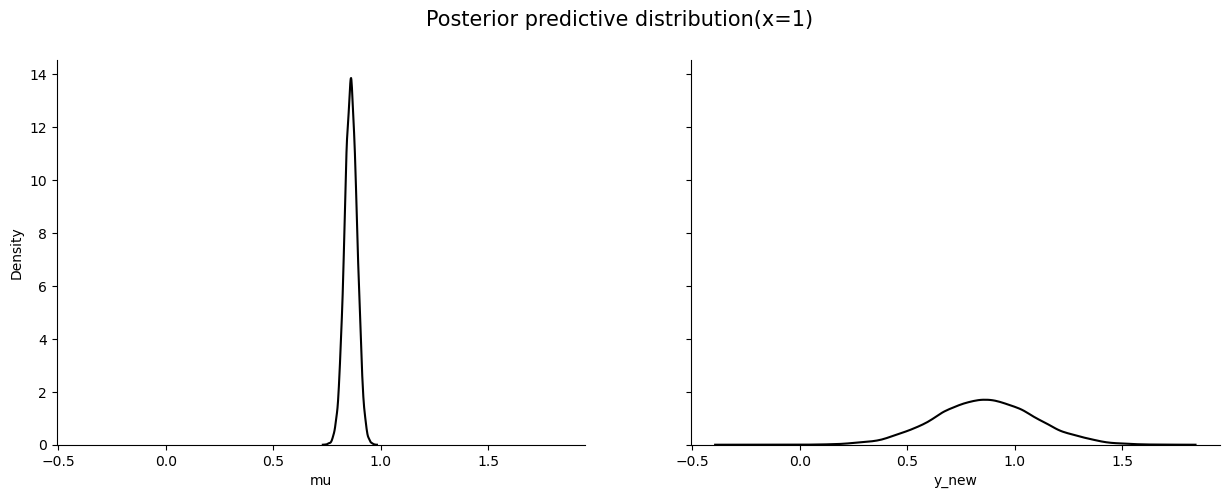

In [24]:
#新建画布
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)        

#在第一个画布中绘制出生成的mu的分布
sns.kdeplot(data=df_pos_sample,                                                
            x="mu", 
            color="black",
            ax=axs[0])

#在第二个画布中绘制出生成的y_new的分布
sns.kdeplot(data=df_pos_sample,                                                 
            x="y_new", 
            color="black",
            ax=axs[1])

fig.suptitle('Posterior predictive distribution(x=1)', fontsize=15)
sns.despine()

从上图可以看到， $Y_{new}$ 分布的不确定性远大于 $\mu$ 分布的不确定性：  

- $\mu$ 分布窄且集中，反映了模型的稳定预测中心；  
- 而 $Y_{new}$ 分布较宽，反映了模型的不确定性。  

> 正如之前提到那样，生成的预测值受到两种变异的影响：  
> * 一是参数估计的不确定性（即 $\beta_0$ 和 $\beta_1$ 的后验分布带来的变异），导致不同样本的均值 $\mu$ 具有差异；  
> * 二是从分布到数据中，另一个参数 $\sigma$ 的影响，进一步放大了预测值 $Y_{\text{new}}$ 的不确定性。这两种变异共同决定了最终预测值的后验预测分布。

### 总体后验预测分布  

* 除了生成特定自变量下，因变量的分布，也可以生成总体因变量的后验预测分布  

* 通过 `pymc.sample_posterior_predictive`方法可以快速从模型生成后验预测数据。  
* 可以看到 ppc_data 中多了一项 posterior_predictive

In [25]:
with linear_model:
    ppc_data = pm.sample_posterior_predictive(trace)

ppc_data

Sampling: [y_est]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

接着，我们可以使用 arviz 提供的后验预测检查函数 `plot_ppc`来绘制结果。  

- 黑色线条代表观测值总体的分布情况。  

- 蓝色线代表每一对采样参数对应的后验预测的分布情况。  

- 橙色为后验预测的均值的分布情况

<Axes: xlabel='y_est'>

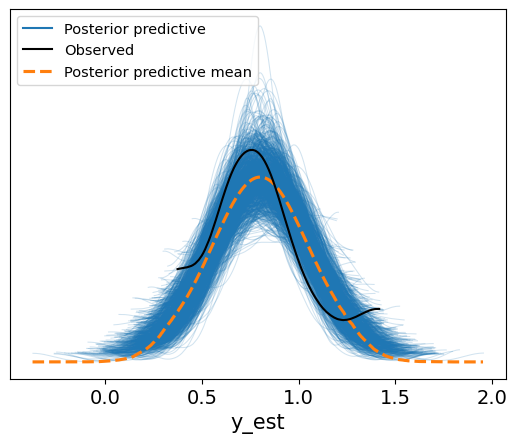

In [26]:
# num_pp_samples 参数代表从总的采样(20000)选取多少采样(这里是1000)进行后验预测计算
az.plot_ppc(ppc_data, num_pp_samples=1000) 

### 对新数据的预测  


- 采样得到的后验参数基于编号为"201"的被试数据，到目前为止，我们都在使用后验参数对这一批数据做出后验预测  

- 那么基于编号为"201"的被试数据得出的后验参数估计对其他数据的预测效果如何？  

- 我们可以选用一批新的数据，查看当前参数是否能预测新数据(例如 "205")中的变量关系

In [27]:
# 筛选编号为“205”的被试的数据
df_new = df_raw[(df_raw["Subject"] == "205") & (df_raw["Matching"] == "Matching")]

# 选择需要的两列
df_new  = df[["Label", "RT_sec"]]

#设置索引
df_new["index"] = range(len(df_new))
df_new = df_new.set_index("index")

# 显示部分数据
df_new.head()

,Label,RT_sec
index,,
0,1,0.753
1,1,0.818
2,1,0.917
3,1,0.717
4,1,0.988


In [28]:
import xarray as xr
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

def plot_posterior_predictive(df, trace, ax=None, title = "Posterior Predictive"):
    """
    绘制后验预测线性模型，展示不同 Label 条件下的平均反应时间 (RT) 及其不确定性。
    
    参数:
    - df : pandas.DataFrame
        包含实验数据的 DataFrame，其中需要包括 'Label' 和 'RT_sec' 两列。
    - trace : arviz.InferenceData
        包含后验参数的 ArviZ InferenceData 对象，需要包括 `beta_0` 和 `beta_1`。
    - ax : matplotlib.axes.Axes, optional
        用于绘制图像的 matplotlib 轴对象。如果未提供，将自动创建一个新的轴对象。
        
    Returns:
    - ax : matplotlib.axes.Axes
        返回绘制了图形的 matplotlib 轴对象。
    
    说明:
    该函数首先将 `Label` 列转换为 xarray 数据格式，以用于生成后验预测模型。接着，
    基于后验参数 `beta_0` 和 `beta_1` 计算模型预测的 `y_model`，并对每个 `Label`
    组内的反应时间 (`RT_sec`) 计算均值。在此基础上，使用 ArviZ 的 `plot_lm` 绘制
    后验预测线性模型，并设置图例、坐标轴范围、标签和其他样式。
    """
    # 如果没有提供 ax，则创建新的图形和轴对象
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # 导入真实的自变量
    x_value = xr.DataArray(df.Label)

    # 基于后验参数生成 y_model
    trace.posterior["y_model"] = trace.posterior["beta_0"] + trace.posterior["beta_1"] * x_value
    df['Mean RT'] = df.groupby('Label')['RT_sec'].transform('mean')

    # 绘制后验预测线性模型
    az.plot_lm(
        y=df['Mean RT'],
        x=df.Label,
        y_model=trace.posterior["y_model"],
        y_model_mean_kwargs={"color":"black", "linewidth":2},
        textsize=16,
        grid=False,
        axes=ax  # 使用传入的轴对象
    )

    # 设置坐标轴标题、范围和字体大小
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0, 1])
    ax.set_ylim(0.65, 0.95)
    ax.set_xlabel('Label')
    ax.set_ylabel('RT (sec)')
    ax.legend(['observed mean', 'Uncertainty in mean', 'Mean'])
    ax.set_title(title)

    # 去除顶部和右侧边框
    sns.despine(ax=ax)

    # 返回轴对象
    return ax


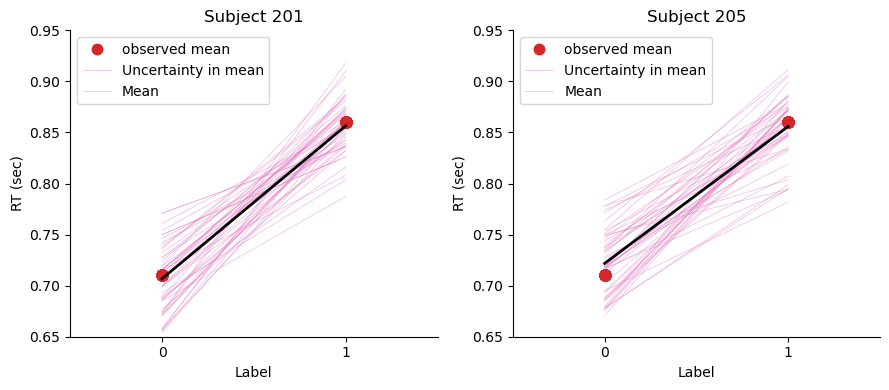

In [29]:
fig, axes = plt.subplots(1,2, figsize=(9,4))

plot_posterior_predictive(df, trace, axes[0], "Subject 201")
plot_posterior_predictive(df_new, trace, axes[1], "Subject 205")

plt.tight_layout()
plt.show()

## 后验推断  

我们共得到20000对$\beta_0$和$\beta_1$值，可以通过`az.summary()`总结参数的基本信息  

- 此表包含了模型的诊断信息，例如参数的均值、标准差和有效样本大小（ess_bulk 和 ess_tail）。  
- 还提供了每个参数的 94% 最高密度区间（HDI），用于展示参数的不确定性范围。

In [80]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.712,0.036,0.645,0.780,0.0,0.0,10456.0,11282.0,1.0
beta_1,0.148,0.046,0.061,0.235,0.0,0.0,10272.0,11248.0,1.0
sigma,0.231,0.016,0.202,0.262,0.0,0.0,12876.0,12118.0,1.0
y_model[0],0.860,0.029,0.806,0.916,0.0,0.0,21700.0,15504.0,1.0
y_model[1],0.860,0.029,0.806,0.916,0.0,0.0,21700.0,15504.0,1.0
...,...,...,...,...,...,...,...,...,...
y_model[100],0.712,0.036,0.645,0.780,0.0,0.0,10456.0,11282.0,1.0
y_model[101],0.712,0.036,0.645,0.780,0.0,0.0,10456.0,11282.0,1.0
y_model[102],0.712,0.036,0.645,0.780,0.0,0.0,10456.0,11282.0,1.0
y_model[103],0.712,0.036,0.645,0.780,0.0,0.0,10456.0,11282.0,1.0


* 我们可以使用均值来理解生成的后验分布，通过上表我们知道  

	*  $\beta_0$ 表示 self 条件下的基准反应时间约为 0.796 秒。  

	*  $\beta_1$ 表示 self 和 other 条件下的反应时间差异非常小，几乎可以忽略不计。  

* 注意：尽管表中显示了参数的均值，但这些均值只是后验分布的一个概要信息。  
	*  我们还可以从 HDI 和标准差中观察到后验分布的广泛性，反映了模型的内在不确定性。  
	*  因此，仅使用均值生成的回归线并不足以充分展示后验分布的复杂性和不确定性。

上节课我们学习了使用 HDI + ROPE 进行检验。在这里我们假设 ($\beta_1$) 的值在 $[-0.05, 0.05]$ 范围内可以视为实用等效，  

即如果$\beta_1$落在这个范围内，说明 self 和 other 条件之间的反应时间差异可以忽略不计，从而在实践上认为两者无显著差异。  

1. **ROPE 区间**：我们设定 $[-0.05, 0.05]$ 为 ROPE 区间，表示 self 和 other 条件下的反应时间差异在此范围内被视为无显著差异。该范围表示了对“等效零效应”的假设，即认为微小的差异在实践中可以忽略。  

2. **HDI (Highest Density Interval)**：后验分布的 95% 最高密度区间（HDI）显示了 $\beta_1$ 的不确定性范围，帮助我们了解后验分布中最可信的值区域。  

3. **结果解读**：  
   - 如果 $\beta_1$ 的后验分布大部分位于 ROPE 区间内，我们可以认为 self 和 other 条件下的反应时间差异在实用上无显著意义，即这两种条件在反应时间上几乎等同。  
   - 如果后验分布的很大一部分超出了 ROPE 区间，则表明 self 和 other 条件之间的差异在实用上具有显著性，值得进一步关注。  


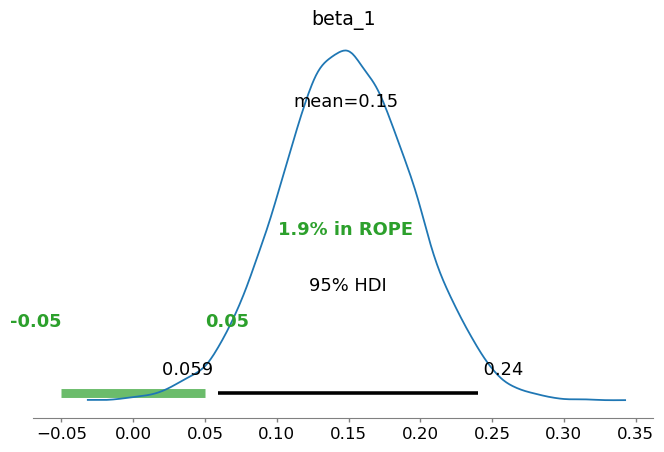

In [82]:
import arviz as az

# 定义 ROPE 区间，根据研究的需要指定实际等效范围
rope_interval = [-0.05, 0.05]

# 绘制后验分布，显示 HDI 和 ROPE
az.plot_posterior(
    trace,
    var_names="beta_1",
    hdi_prob=0.95,
    rope=rope_interval,
    figsize=(8, 5),
    textsize=12
)

plt.show()


我们可以看到 $\beta_1$ 的后验分布主要集中在正值区域，其均值约为 0.15。  

图中的 95% 最高密度区间（HDI）范围为 $[0.059, 0.24]$，且大部分后验分布落在 ROPE 区间 $[-0.05, 0.05]$ 之外，只有 1.9% 的后验分布位于 ROPE 区间内。  

这表明 self 和 other 条件下的反应时间差异在实践上具有显著性，即 $\beta_1$ 的值足够大，可以排除两者在反应时间上的实用等效性。因此，self 和 other 条件之间的差异值得关注。

## 总结  

* 本节课通过一个简单的线性回归示例，展示了如何使用 PyMC 构建贝叶斯模型，并结合之前的内容对模型结果进行深入分析。  
  * 我们特别关注了先验和后验预测检查的重要性，以评估模型的合理性和预测能力。  
* 此外，我们介绍了如何使用 bambi 来简化线性模型的定义和拟合，使得贝叶斯建模的流程更加便捷。。  
* 最后，我们强调了贝叶斯建模中的关键步骤，从模型构建到结果解释，并认识到 MCMC 方法在近似后验分布中的重要性。  


![Image Name](https://cdn.kesci.com/upload/smkhdwv5zt.png?imageView2/0/w/720)

## 使用bambi进行模型定义  

Bambi 是一个用于贝叶斯统计建模的 Python 包，建立在 PyMC 上。  

```pyhon  
model = bmb.Model('RT_sec ~ Label',  
                  data=df,  
                  dropna=True)  
```

* 它提供了一个更加简化的界面，使得使用贝叶斯统计模型更加容易，特别是在处理线性和广义线性混合模型时。  

* 上面的代码提供了一个示例，我们可以简单的三行代码来完成之前的回归模型的定义。  

* 其中，我们可以通过 lme4 的形式来表达线性关系：`'RT_sec ~ Label'`。~左边是因变量，右边是自变量。  
 
* 需要注意的是，在bambi中，如果我们不对先验进行定义，它会自动选择一个比较弱(weakly informative)的先验。

我们通过代码示例来说明如何通过 bambi 复现之前的分析：  

1. 首先定义模型

In [ ]:
import bambi as bmb

#定义先验并传入模型中
beta_0 = bmb.Prior("Normal", mu=5, sigma=2)  
beta_1 = bmb.Prior("Normal", mu=0, sigma=1)        
sigma = bmb.Prior("Exponential", lam = 0.3)         

# 将三个参数的先验定义在字典prior中
priors = {"beta_0": beta_0, 
          "beta_1": beta_1,
          "sigma": sigma}

#定义关系式，传入数据
model = bmb.Model('RT_sec ~ Label', 
                  data=df,
                  priors=priors,
                  dropna=True)
#总结对模型的设置
model

2. 拟合模型，使用MCMC方法采样得到后验的近似分布  

- 提示：`model.fit` 基于 `pm.sample` 方法。因此，他们的参数设置是相同可继承的。

In [ ]:
#===========================
#      MCMC采样过程
#      注意！！！以下代码可能需要运行几分钟
#===========================
trace = model.fit(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                  tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                  chains=4,
                  random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Label]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


模型诊断部分的分析和之前直接使用 PyMC 是一致的。

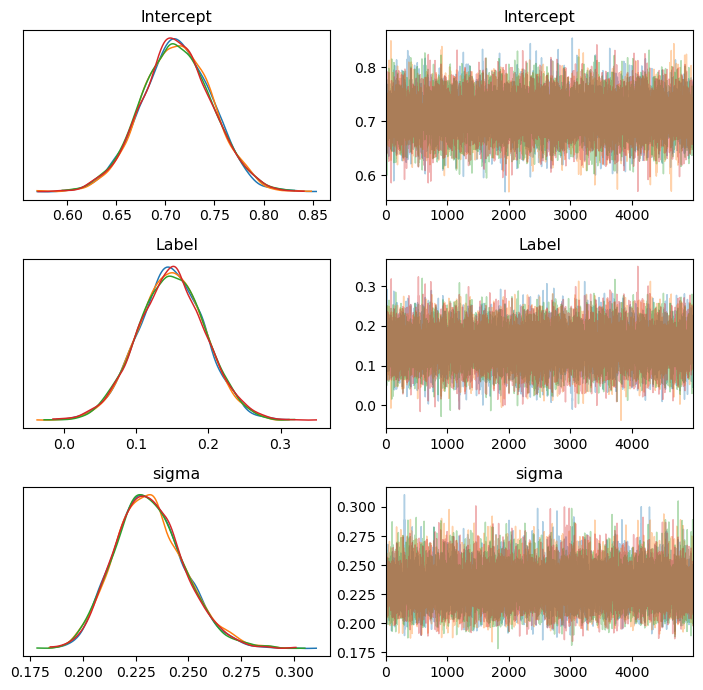

In [ ]:
ax = az.plot_trace(trace, figsize=(7,7), compact=False)
plt.tight_layout()
plt.show()

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.712,0.036,0.646,0.781,0.0,0.0,29217.0,15473.0,1.0
Label,0.149,0.046,0.063,0.237,0.0,0.0,28821.0,15726.0,1.0
sigma,0.232,0.016,0.202,0.262,0.0,0.0,29176.0,15618.0,1.0


## 补充材料：为什么使用MCMC是必要的  

>我们都知道当后验分布的计算过于复杂时，我们应该选用MCMC来近似后验分布  

>但是在这里后验分布究竟有多复杂呢，这里提供了直接的计算(or提供一些复杂的公式让人知难而退)：  

1. 该线性模型存在三个参数值$(\beta_0, \beta_1, \sigma)$  
	* 那么先验概率则为三者pdf的乘积：  
$$  
 f(\beta_0, \beta_1, \sigma) = f(\beta_0) f(\beta_1) f(\sigma)  
$$  

2. 观测到的数据可以用$\vec{y} = (y_1,y_2,...,y_{n})$来表示  
	* 那么似然函数可以表示为：  
$$  
 L(\beta_0, \beta_1, \sigma | \vec{y}) = f(\vec{y}|\beta_0, \beta_1, \sigma) = \prod_{i=1}^{n}f(y_i|\beta_0, \beta_1, \sigma)  
 $$  

3. 后验分布则可以表示为：  
$$  
\begin{split}  
f(\beta_0,\beta_1,\sigma \; | \; \vec{y})  
 & = \frac{\text{prior} \cdot \text{likelihood}}{ \int \text{prior} \cdot \text{likelihood}} \\  
 & = \frac{f(\beta_0) f(\beta_1) f(\sigma) \cdot \left[\prod_{i=1}^{n}f(y_i|\beta_0, \beta_1, \sigma) \right]}  
 {\int\int\int f(\beta_0) f(\beta_1) f(\sigma) \cdot \left[\prod_{i=1}^{n}f(y_i|\beta_0, \beta_1, \sigma) \right] d\beta_0 d\beta_1 d\sigma} \\  
 \end{split}  
 $$  
